In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
%matplotlib inline

In [550]:
boltzmann_k = 1.0

def hopping(params, r):
    return - params.eps*params.cons*(params.afcc/r)**params.q/2.

def deriv_hopping(params,r):
    return params.eps*params.cons*params.q*params.afcc**params.q/r**(params.q+1)/2.

def build_h(dim, params, r):
    h = np.zeros((dim,dim),dtype=np.complex128)
    factor = hopping(params,r)
    for i in range(0,dim):
        h[i,np.mod(i-1,dim)] = factor
        h[np.mod(i-1,dim),i] = h[i,np.mod(i-1,dim)]
    return h

def build_s(dim, params, r):
    s = np.zeros((dim,dim),dtype=np.complex128)
    factor = - hopping(params,r)
    factor = factor / 100.     # I defined S(i,j) = -hopping(i,j)/100 to ensure positive definiteness
    for i in range(0,dim):
        s[i,i] = 1.0
        s[i,np.mod(i-1,dim)] = factor
        s[np.mod(i-1,dim),i] = s[i,np.mod(i-1,dim)]
    return s

def build_dh(dim, params, r, atom):
    dh = np.zeros((dim,dim),dtype=np.complex128)
    factor = (-1)**(atom+1) * deriv_hopping(params,r)
    dh[atom,np.mod(atom-1,dim)] = factor
    dh[np.mod(atom-1,dim),atom] = dh[atom,np.mod(atom-1,dim)]
    return dh

def build_ds(dim, params, r, atom):
    ds = np.zeros((dim,dim),dtype=np.complex128)
    factor = - (-1)**(atom+1) * deriv_hopping(params,r)
    factor = factor / 100.
    ds[atom,np.mod(atom-1,dim)] = factor
    ds[np.mod(atom-1,dim),atom] = ds[atom,np.mod(atom-1,dim)]
    return ds

def build_rdds(dim, params, veloc, r):
    rdotds = np.zeros((dim,dim),dtype=np.complex128)
    for i in range(dim):
        dsi = build_ds(dim, params, r, i)
        rdotds[:,i] = dsi[:,i]*veloc[i]
    return rdotds

def fermif(energy, mu, temp):
    expo = (energy-mu)/(temp*boltzmann_k)
    if expo < -100.0:
        return 1.0
    elif expo > 100.0:
        return 0.0
    else:
        return 1.0/(np.exp(expo)+1.0)

def repulsive(params,r):
    return params.eps*(params.afcc/r)**params.p

def deriv_repulsive(params,r,atom):
    return - (-1)**(atom+1)*params.eps*params.p*params.afcc**params.p/r**(params.p+1)

def energy(rho,h,params,r,veloc,mass):
    return np.trace(np.dot(rho,h)).real + repulsive(params,r) + 0.5*mass*sum(veloc**2), \
        np.trace(np.dot(rho,h)).real, repulsive(params,r), 0.5*mass*sum(veloc**2)

def kinetic(veloc,mass):
    return 0.5*mass*sum(veloc**2)

def forces(rho,sinv,h,params,r,atom):
    dh1 = build_dh(dim, params, r, atom)
    ds1 = build_ds(dim, params, r, atom)
    drep1 = deriv_repulsive(params,r,atom)
    aux = dh1 + 0.5*(np.dot(ds1,np.dot(sinv,h))+np.dot(np.dot(h,sinv),ds1))
    force = - np.trace(np.dot(rho,aux)).real
    force += - drep1
    return force

In [458]:
class h2_params:
    def __init__(self):
        self.eps = 0.007
        self.afcc = 3.61
        self.p = 9
        self.q = 3
        self.cons = 112.

In [555]:
dim = 2
r = 2.2
mass = 100.
coord = np.array([0.0, r])
veloc = np.zeros((dim))
#veloc = np.random.random(2)/100.

force = np.zeros((dim))
folceold = np.zeros((dim))
dt = 0.02
params = h2_params()
h = build_h(dim, params, r)
s = build_s(dim, params, r)
sinv = linalg.inv(s)

w, v = linalg.eigh(h, b=s, lower=True)
occ = np.zeros((dim, dim))
for i in range(0, dim):
    occ[i, i] = fermif(w[i].real, mu=0.0, temp=0.00000001)
rho = 2.0 * np.dot(v, np.dot(occ, v.conjugate().T))

In [556]:
rdotds = build_rdds(dim, params, veloc, r)
rhodot = (0-1.0j)*(np.dot(sinv,np.dot(h,rho))-np.dot(np.dot(rho,h),sinv))
rhodot += -(np.dot(sinv,np.dot(rdotds,rho))+np.dot(np.dot(rho.conjugate(),rdotds.T),sinv))
rhoold = rho - 1.0 * dt * rhodot

for i in range(dim):
    force[i] = forces(rho,sinv,h,params,r,i) #F_0
    veloc[i] = veloc[i] + 0.5*force[i]/mass*dt

In [557]:
nsteps = 2000
traza = np.zeros((nsteps))
time = np.zeros((nsteps))
distance = np.zeros((nsteps))
rho11 = np.zeros((nsteps),dtype=np.complex128)
over = np.zeros((nsteps),dtype=np.complex128)
energies = np.zeros((4,nsteps))
kin = np.zeros((nsteps))
for step in range(0, nsteps):
    
    rdotds = build_rdds(dim, params, veloc, r) #v_0

    rhodot = (0-1.0j)*(np.dot(sinv,np.dot(h,rho))-np.dot(np.dot(rho,h),sinv))
    rhodot += -(np.dot(sinv,np.dot(rdotds,rho))+np.dot(np.dot(rho.conjugate().T,rdotds.T),sinv))
    rhonew = rhoold + 2.0 * dt * rhodot
    rhoold = rho 
    rho = rhonew #rho is rho_1

    for i in range(dim):
        coord[i] = coord[i]+veloc[i]*dt+0.5*force[i]/mass*dt*dt #Coord is r_1, Veloc is v_0, force is F_0
        
    forceold = force #Forceold is F_0
    r = np.abs(coord[1]-coord[0])
    h = build_h(dim, params, r) #H_1
    s = build_s(dim, params, r) #S_1
    sinv = linalg.inv(s) #Sinv_1 
    
    for i in range(dim):
        force[i] = forces(rho,sinv,h,params,r,i) #F_1
        veloc[i] = veloc[i] + 0.5*(force[i]+forceold[i])*dt/mass #v_1
    
    time[step] = step*dt
    distance[step] = r
    traza[step] = np.trace(np.dot(rho,s)).real
    rho11[step] = rho[0,0]
    over[step] = s[0,1]
    energies[:,step] = energy(rho,h,params,r,veloc,mass) #total, electronic, repulsive, kinetic

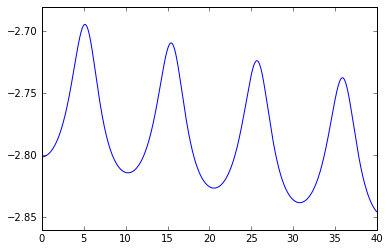

In [560]:
plt.plot(time,energies[0,:])

Some results:

dt = 0.0002, 200000 steps

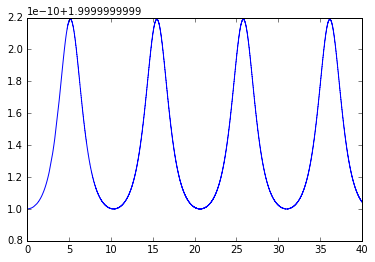

In [509]:
plt.plot(time,traza)

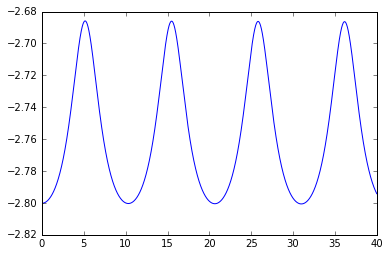

In [510]:
plt.plot(time,energies[0,:])

dt = 0.002, 20000 steps

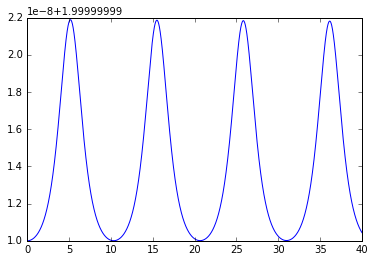

In [503]:
plt.plot(time,traza)

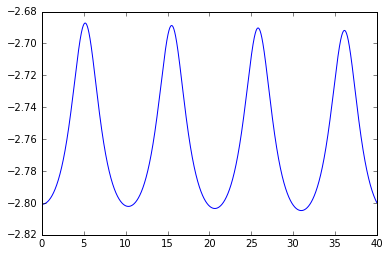

In [505]:
plt.plot(time,energies[0,:])

dt = 0.02, 2000 steps

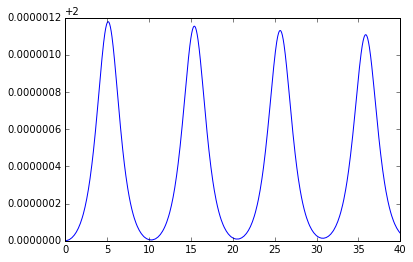

In [497]:
plt.plot(time,traza)#,time,kin)
#plt.xlim(10,50)

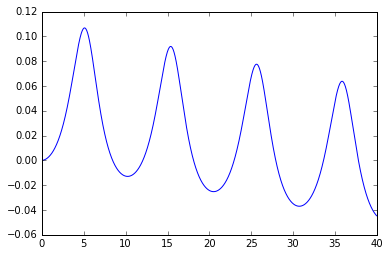

In [499]:
plt.plot(time,energies[0,:]-energies[0,0])
#plt.plot(time,energies[1,:]-energies[1,0])
#plt.plot(time,energies[2,:]-energies[2,0])
#plt.plot(time,energies[3,:]-energies[3,0])

#plt.xlim(10,20)

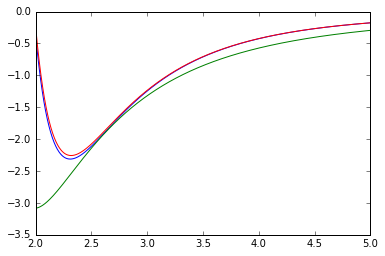

In [311]:
#check forces and energies
dim = 2
params = h2_params()
x = np.linspace(2.,5.0,1000)
energs = np.zeros((1000))
fuerzas = np.zeros((1000))
for j,r in enumerate(x):
    h = build_h(dim, params, r)
    s = build_s(dim, params, r)
    sinv = linalg.inv(s)
    w, v = linalg.eigh(h, b=s, lower=True)
    occ = np.zeros((dim, dim))
    for i in range(0, dim):
        occ[i, i] = fermif(w[i].real, mu=0.0, temp=0.000001)
    rho = 2.0 * np.dot(v, np.dot(occ, v.conjugate().T))
    fuerzas[j] = forces(rho,sinv,h,params,r,1)
    energs[j] = energy(rho,h,params,r)
plt.plot(x,fuerzas,x,energs)
fuerzas2 = -np.diff(energs)/(x[1]-x[0])
plt.plot(x[0:-1],fuerzas2)